In [1]:
%load_ext autoreload
%autoreload 2

import os
# Run everything on CPU, if GPU is available comment out
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""


import sys
sys.path.append("src/")
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import numpy as np
from tensorflow import keras
from functools import partial

from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    seq_contains_mdm2_motif,
    seq_contains_12ca5_motif,
    benchmark_cross_validated_hit_rate,
)
from analysis.scatter_plots import (
    plot_fancy_hexbin_relations
)
from models.rnn import multi_channel_mse

2023-06-20 16:12:25.187495: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 16:12:25.314484: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-20 16:12:25.801943: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64:/usr/local/cuda-11.0/lib64
2023-06-20 16:12:25.801996: W ten

In [2]:
protein_of_interest = "MDM2"
other_protein = "12ca5"

def proxy_ranking_lambda(x):
    # Proxy metric is defined as FC (y_raw[:, 1]) + ER (y_raw[:, 2])
    return x[1] + x[2]

top_k_size = 500 if protein_of_interest == "MDM2" else 1000
motif_dectection_func = (
    seq_contains_mdm2_motif
    if protein_of_interest == "MDM2"
    else seq_contains_12ca5_motif
)
model_save_name = (
    "final_models/mdm2_model.h5"
    if protein_of_interest == "MDM2"
    else "final_models/12ca5_model.h5"
)


X, y_raw, peptides, FEATURE_LIST = data_loading.build_joint_dataset(
    er_datafile=f"{protein_of_interest}_merged_ER.csv",
    volcano_datafile="12ca5-MDM2-mCDH2-R3.csv",
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
)


/home/yitongt/ml_phage/src/preprocessing/y_representation.py:63: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(


## Baseline Experimental Rankings

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


(-11.26699745539576, 12.802835987110129, -0.8329379238887278, 27.369964117469774)


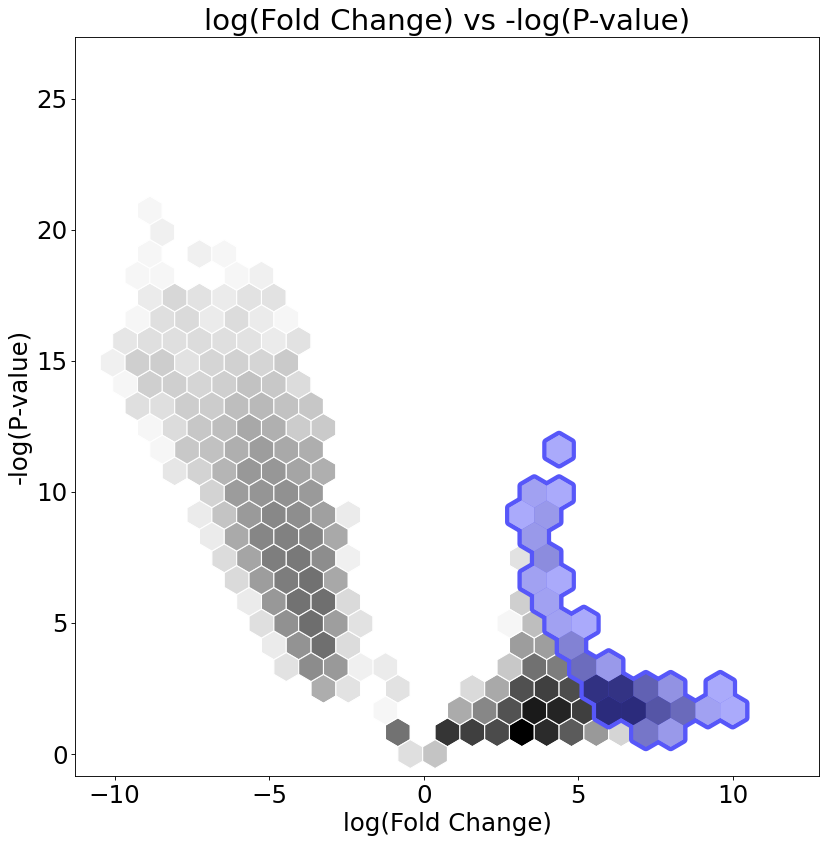

(-11.26699745539576, 12.802835987110129, -0.8329379238887278, 27.369964117469774)


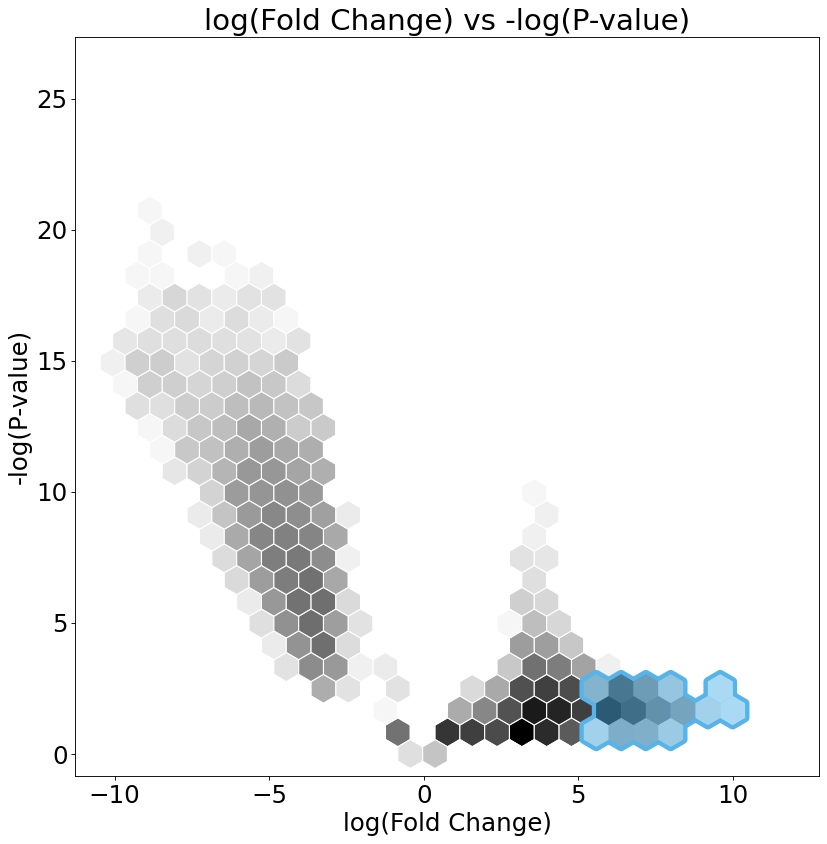

(-12.424972942105276, 18.0343835663439, -11.26699745539576, 12.802835987110129)


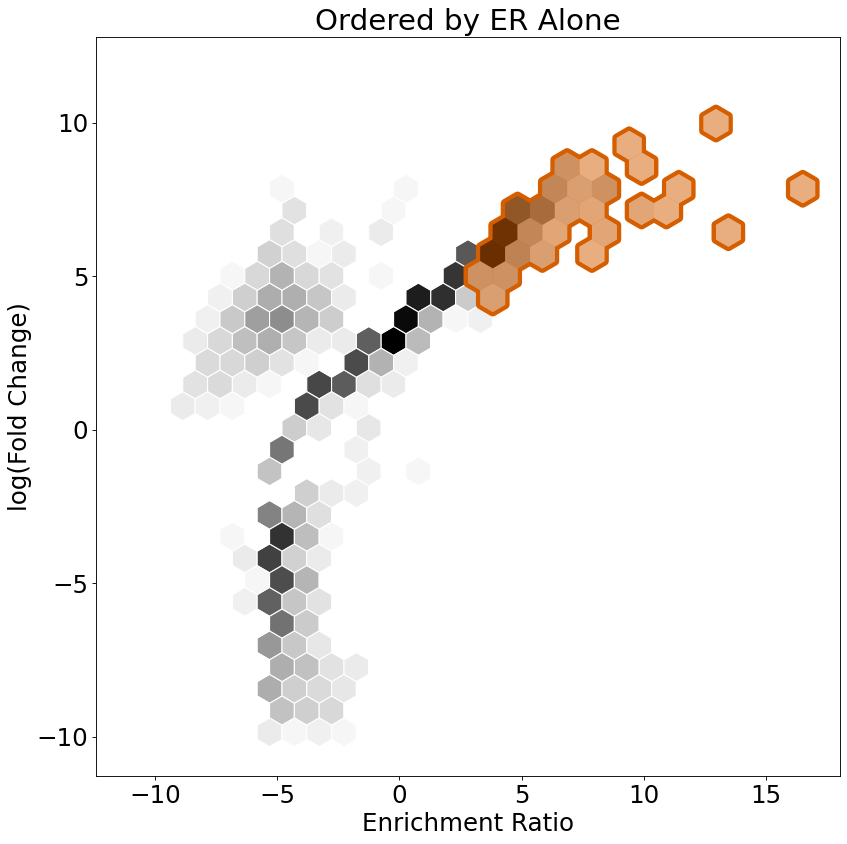

(-12.424972942105276, 18.0343835663439, -11.26699745539576, 12.802835987110129)


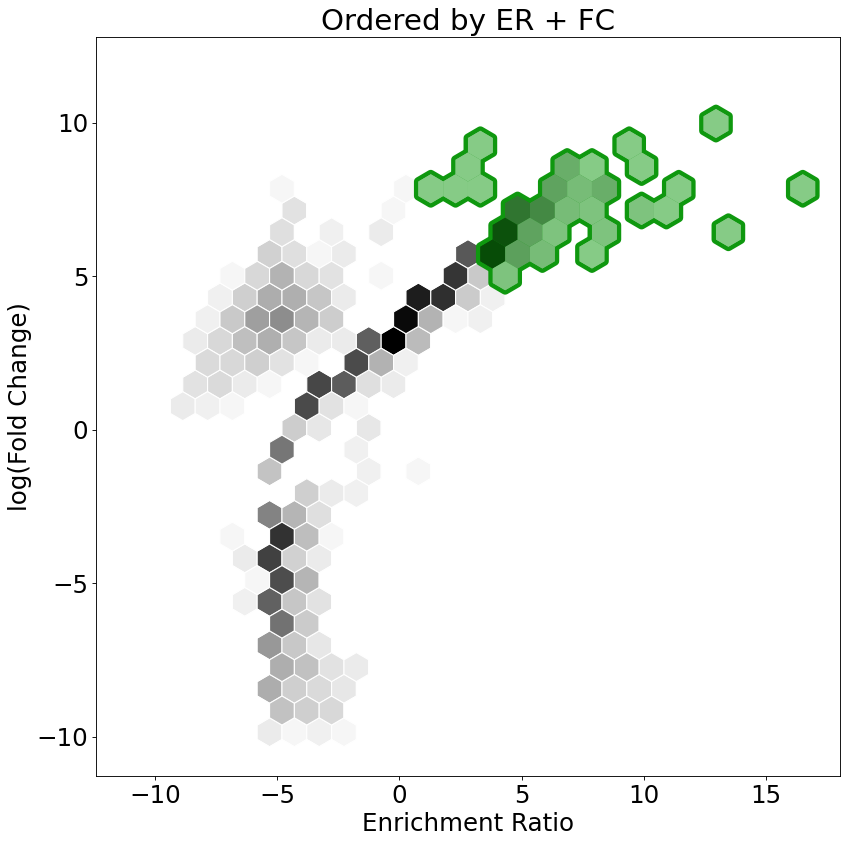

In [3]:
volcano_ordering = (
    np.array([(val[0] + 6) * val[1] if val[1] > 0 else 0 for val in y_raw])
    if protein_of_interest == "MDM2"
    else np.array([val[0] * val[1] for val in y_raw])
)
plot_fancy_hexbin_relations(
    1,
    0,
    datapoints=y_raw,
    ordering=volcano_ordering,
    all_positives=None,
    line_color='#5757F9',
    top_k=top_k_size,
)

fc_alone_mdm2_ordering = [y[1] for y in y_raw]
plot_fancy_hexbin_relations(
    1,
    0,
    datapoints=y_raw,
    ordering=fc_alone_mdm2_ordering,
    all_positives=None,
    line_color='#56B4E9',
    top_k=top_k_size,
)

er_mdm2_ordering = [y[2] for y in y_raw]

plot_fancy_hexbin_relations(
    2,
    1,
    datapoints=y_raw,
    ordering=er_mdm2_ordering,
    all_positives=None,
    line_color='#D55E00',
    title='Ordered by ER Alone',
    top_k=top_k_size,
)

er_fc_joint_mdm2_ordering = [y[2] + y[1] for y in y_raw]
plot_fancy_hexbin_relations(
    2,
    1,
    datapoints=y_raw,
    ordering=er_fc_joint_mdm2_ordering,
    all_positives=None,
    line_color='#0F980F',
    title='Ordered by ER + FC',
    top_k=top_k_size,
)


drop C
max is  75.0


/home/yitongt/ml_phage/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV'))
/home/yitongt/ml_phage/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV'))


drop C
max is  67.0


/home/yitongt/ml_phage/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV'))
/home/yitongt/ml_phage/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV'))


drop C
max is  95.0
drop C
max is  89.0


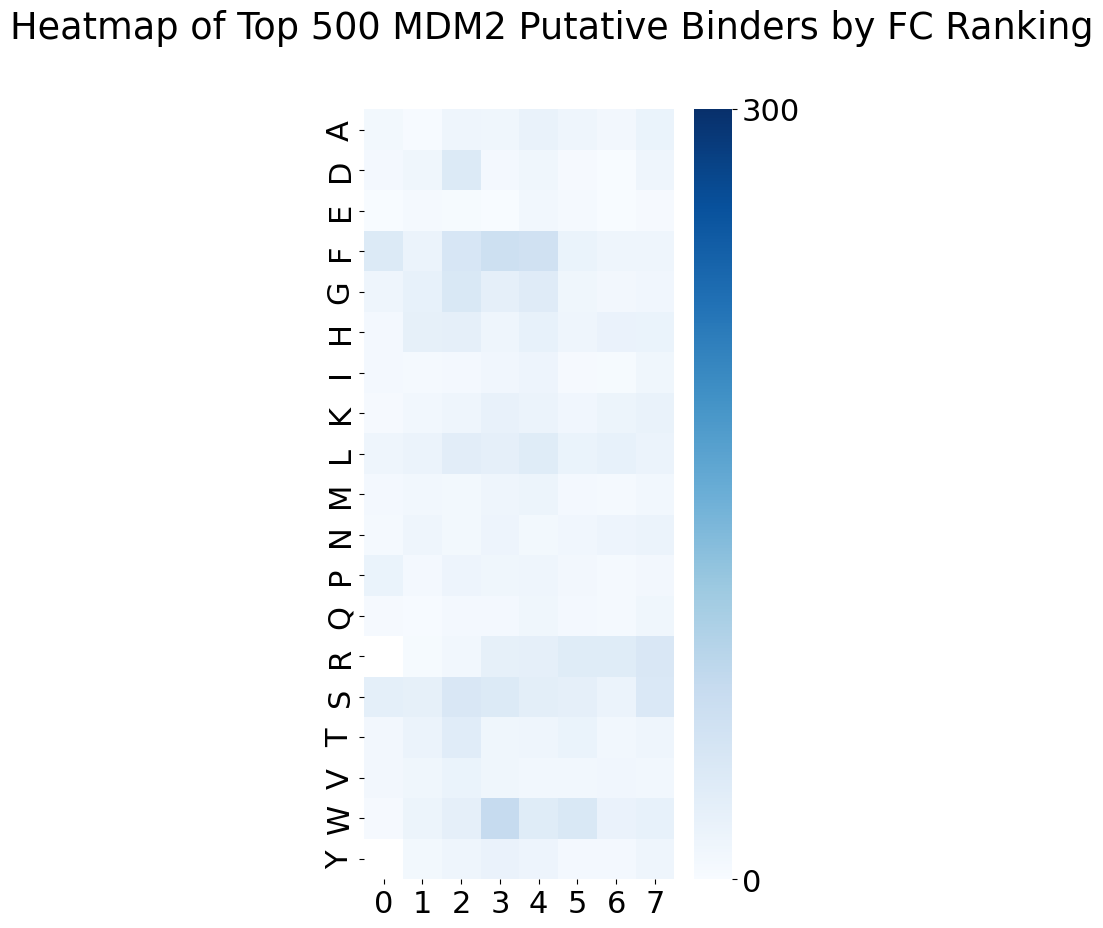

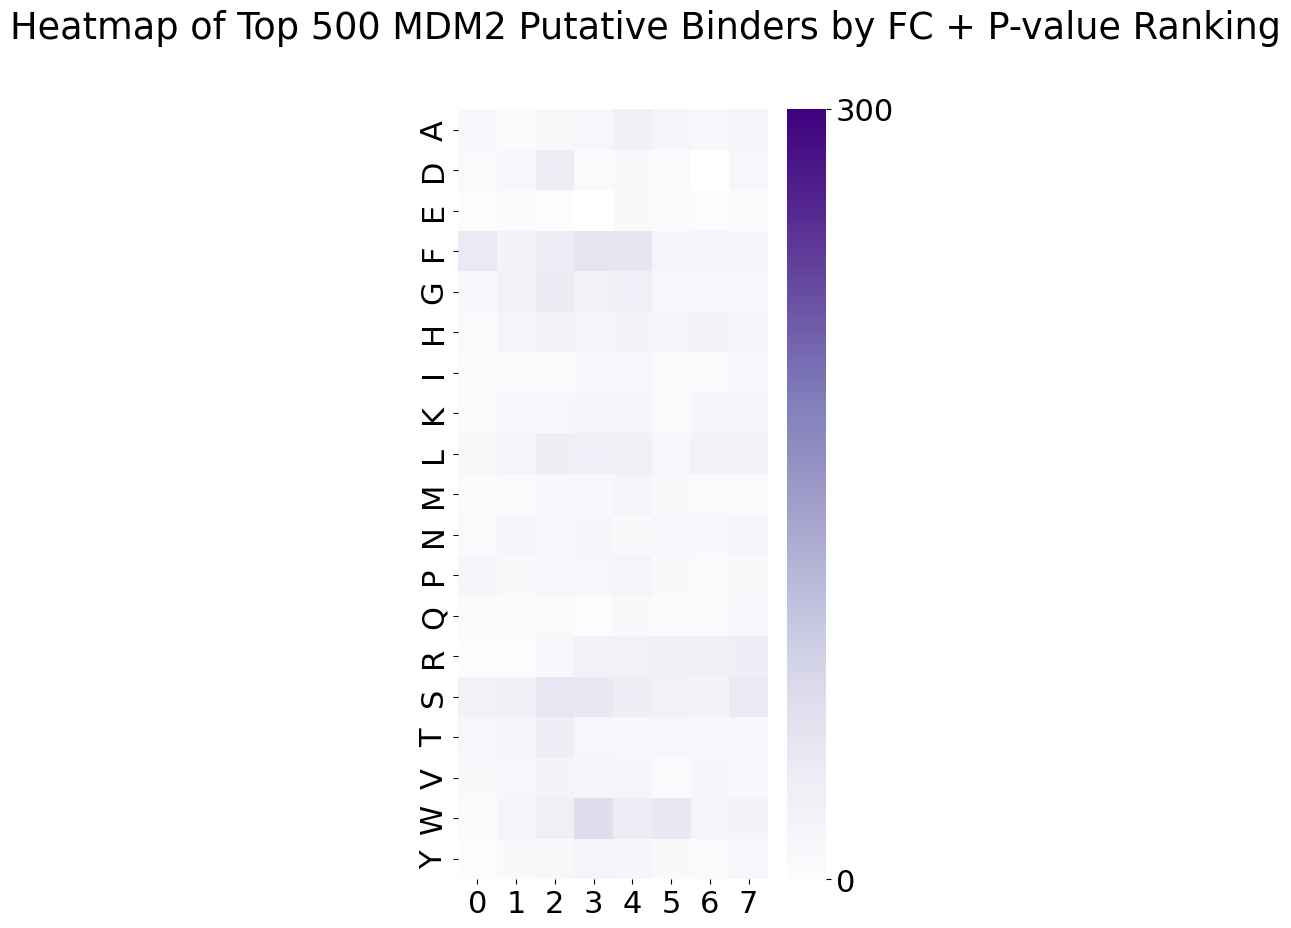

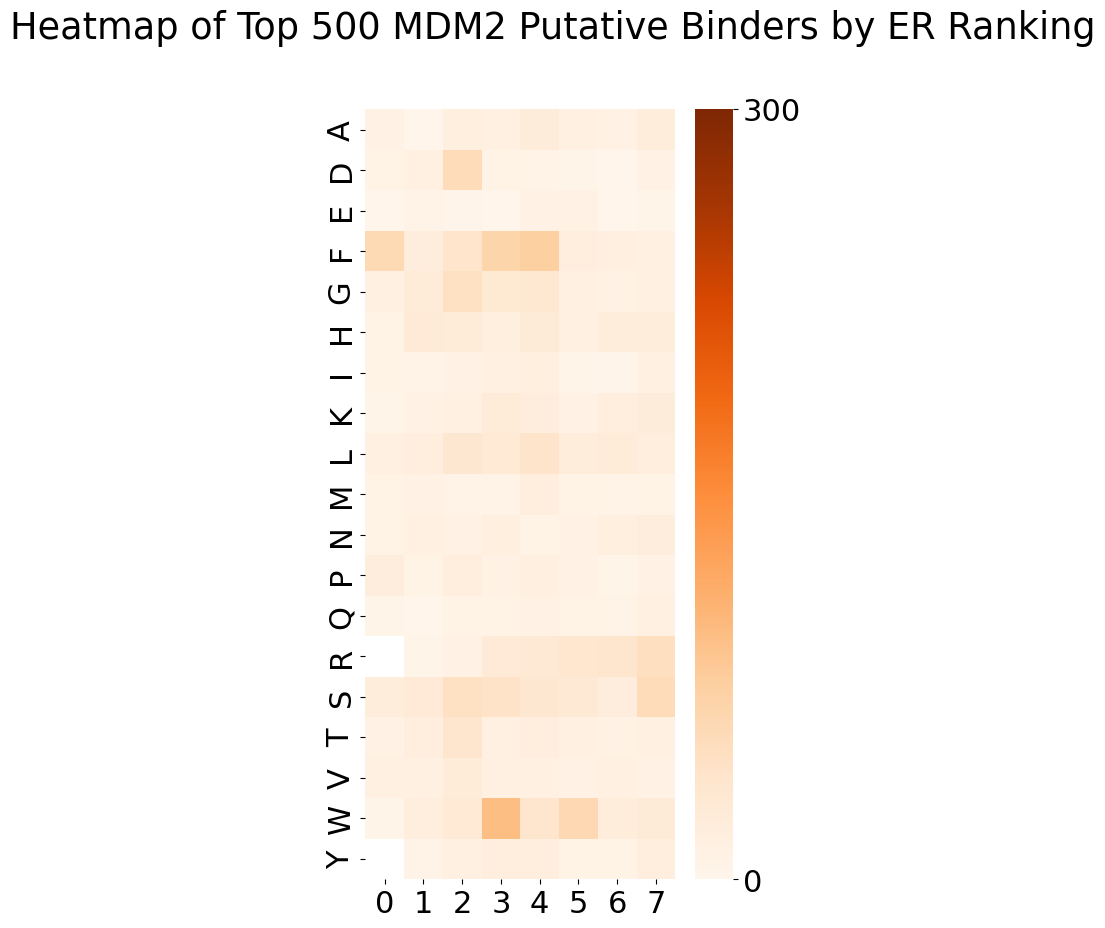

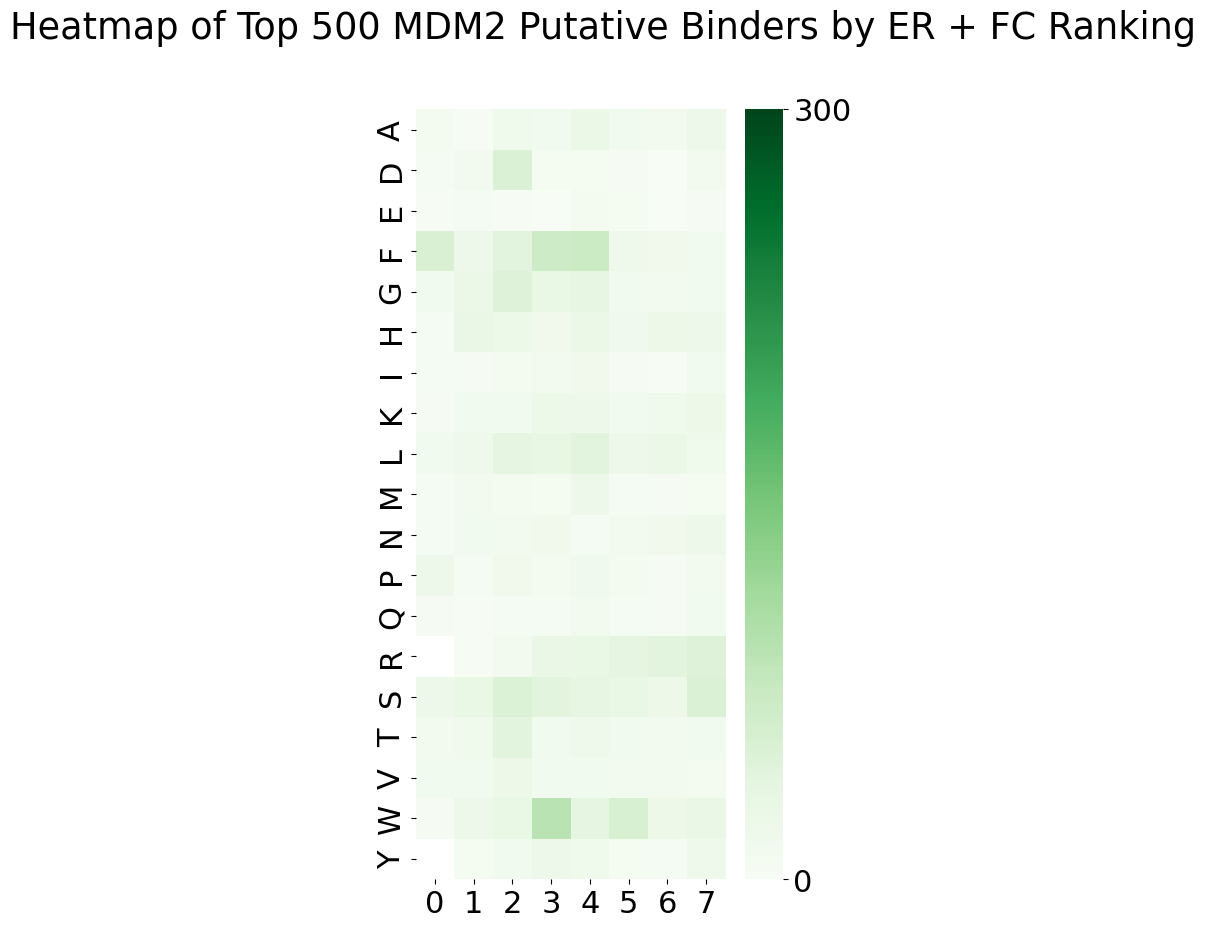

In [4]:
import analysis.heatmap_analysis as heatmap


def show_heatmap_for_top_k(title, ordering, color, peptides=peptides, top_k=top_k_size):
    top_k_mask = ordering >= np.partition(ordering, kth=-top_k)[-top_k]
    top_k_peptides = [pep for pep, mask in zip(peptides, top_k_mask) if mask]

    heatmap.generate_heatmap(
        top_k_peptides, 
        title=title,
        vmax=300 if protein_of_interest == 'MDM2' else 600,
        colormap=color,
    )

show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by FC Ranking", fc_alone_mdm2_ordering, 'Blues')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by FC + P-value Ranking", volcano_ordering, 'Purples')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by ER Ranking", er_mdm2_ordering, 'Oranges')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by ER + FC Ranking", er_fc_joint_mdm2_ordering, 'Greens')

## BiLSTM Ranking

In [5]:
cross_validation_results = experiment.Experiment().run_cross_validation_experiment(
    X=X,
    y=y_raw,
    model_architecture=partial(
        rnn.ThreeChannelRegressionRNN_gelu, loss=multi_channel_mse, width=64
    ),
    optimizer=partial(
        keras.optimizers.Adam, learning_rate=0.0005, weight_decay=0.5
    ),
    n_splits=10,
    load_trained_model=True,
    model_save_name=model_save_name,
    normalize=True,
    batch_size=128,
    num_epochs=5,
)


(-7.122755271379493, 5.768546213644784, 0.41889799885009615, 11.095790609299698)


/home/yitongt/ml_phage/src/analysis/hit_rate_analysis.py:179: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_pred = np.vstack(result.y_pred_rescaled for result in cross_validation_results)
/home/yitongt/ml_phage/src/analysis/hit_rate_analysis.py:180: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(result.y_test for result in cross_validation_results)


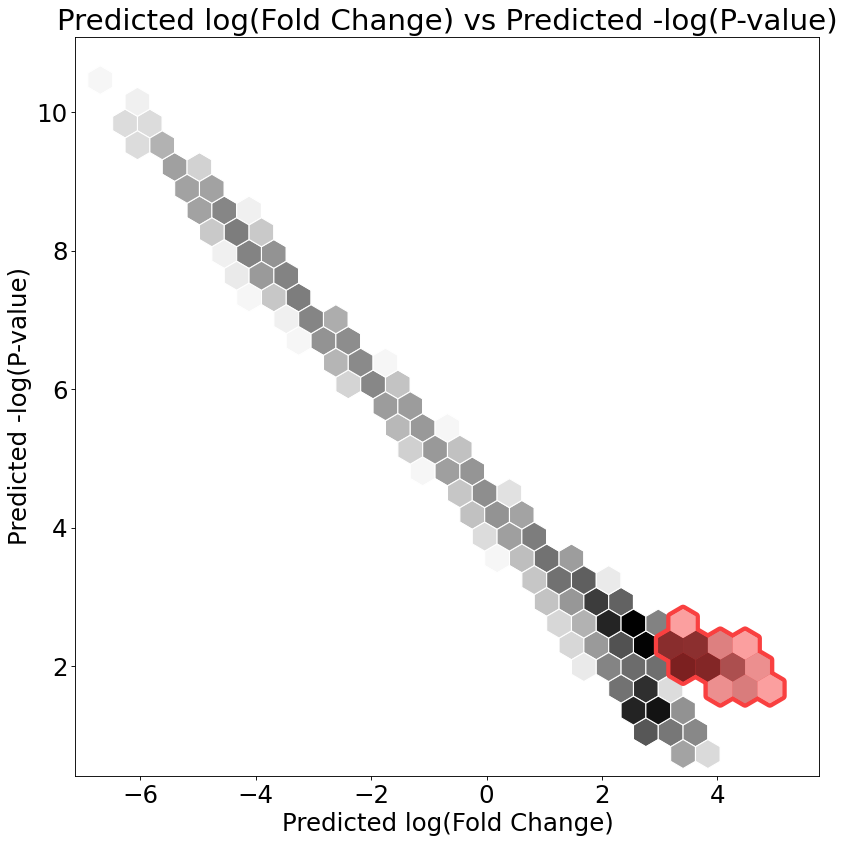

(-7.122755271379493, 5.768546213644784, 0.41889799885009615, 11.095790609299698)


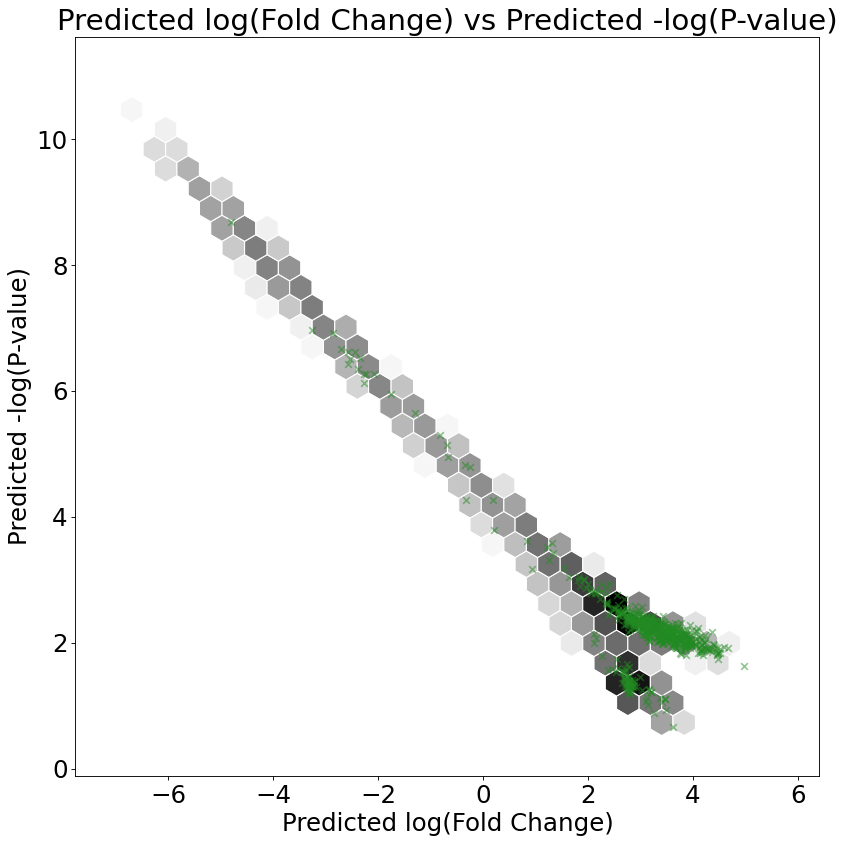

In [6]:
bilstm_ordering, y_pred = benchmark_cross_validated_hit_rate(
    cross_validation_results=cross_validation_results,
    y_raw=y_raw,
    peptides=peptides,
    proxy_ranking_lambda=proxy_ranking_lambda,
    top_k_size=top_k_size,
    motif_dectection_func=motif_dectection_func,
)

drop C
max is  249.0


/home/yitongt/ml_phage/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV'))


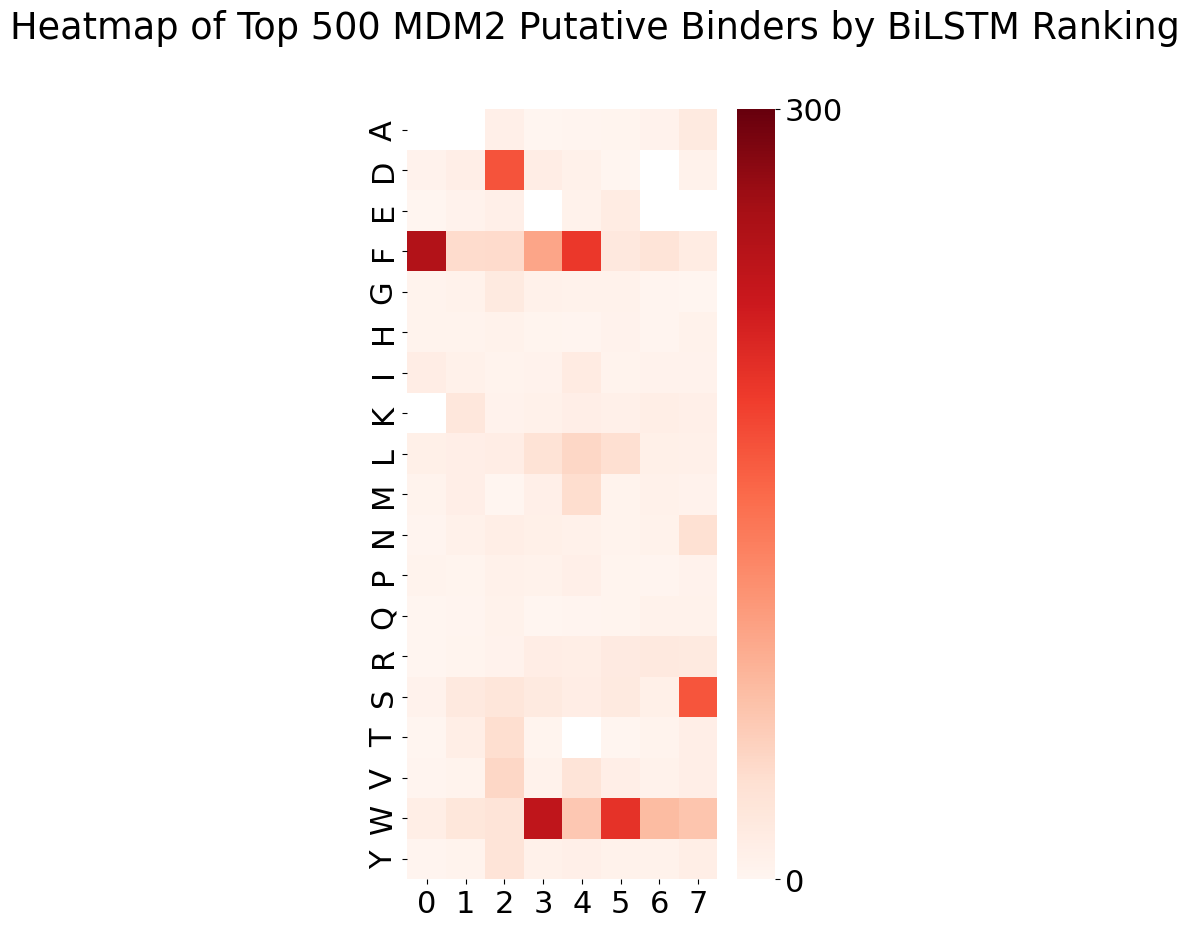

In [7]:
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by BiLSTM Ranking", bilstm_ordering, 'Reds')

## Benchmark

In [8]:

rankings=[
(
    bilstm_ordering, 'BiLSTM Model Ranking', '#F94040'
),
(
    er_mdm2_ordering, 'ER Ranking', '#D55E00'
),
(
    er_fc_joint_mdm2_ordering, 'Joint ER/FC Ranking', '#0F980F'
),
(
    volcano_ordering, 'Joint FC/Pval Ranking', '#5757F9'
),
(
    fc_alone_mdm2_ordering, 'FC Ranking', '#56B4E9'
),
]

In [9]:
from matplotlib.pyplot import figure

figure(figsize=(12, 12), dpi=80)

<Figure size 960x960 with 0 Axes>

<Figure size 960x960 with 0 Axes>

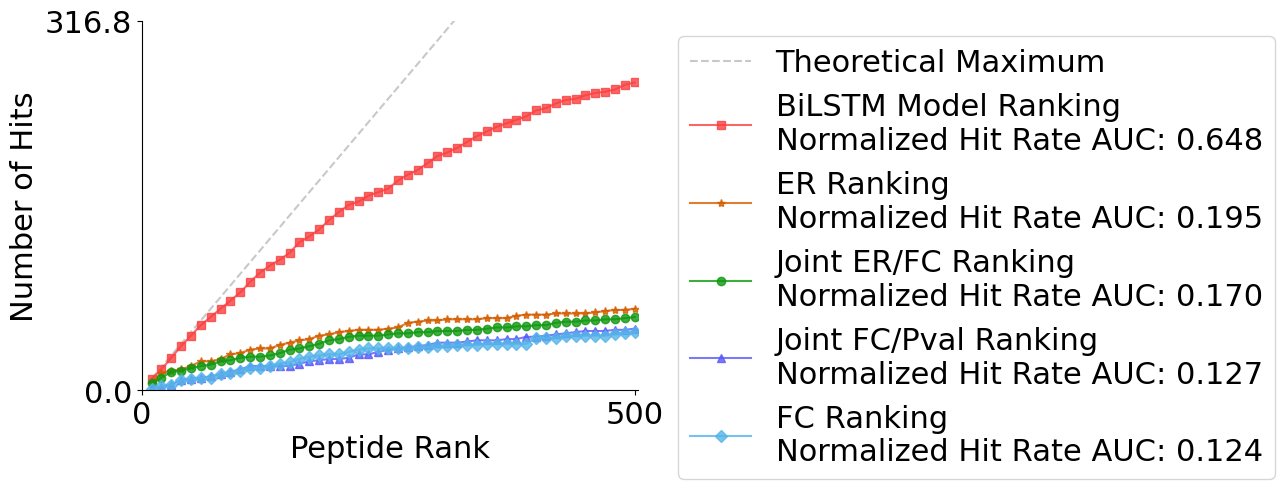

0.647921568627451

In [10]:
plot_ratio_by_ranking(
    peptides=peptides,
    y_rankings=rankings,
    title="",
    peptide_dataset_size=top_k_size,
    hit_rate_func=seq_contains_mdm2_motif if protein_of_interest =="MDM2" else seq_contains_12ca5_motif,
    save_file='mdm2_hit_rankings.csv' if protein_of_interest =='MDM2' else '12ca5_hit_rankings.csv',
)

# Now Hit Rate Benchmarking for 12ca5

In [11]:
protein_of_interest = "12ca5"
other_protein = "MDM2"

def proxy_ranking_lambda(x):
    # Proxy metric is defined as FC (y_raw[:, 1]) + ER (y_raw[:, 2])
    return x[1] + x[2]

top_k_size = 500 if protein_of_interest == "MDM2" else 1000
motif_dectection_func = (
    seq_contains_mdm2_motif
    if protein_of_interest == "MDM2"
    else seq_contains_12ca5_motif
)
model_save_name = (
    "final_models/mdm2_model.h5"
    if protein_of_interest == "MDM2"
    else "final_models/12ca5_model.h5"
)


X, y_raw, peptides, FEATURE_LIST = data_loading.build_joint_dataset(
    er_datafile=f"{protein_of_interest}_merged_ER.csv",
    volcano_datafile="12ca5-MDM2-mCDH2-R3.csv",
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
)


/home/yitongt/ml_phage/src/preprocessing/y_representation.py:63: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(


(-10.735610373902963, 13.334223068602926, -0.8329379238887278, 27.369964117469774)


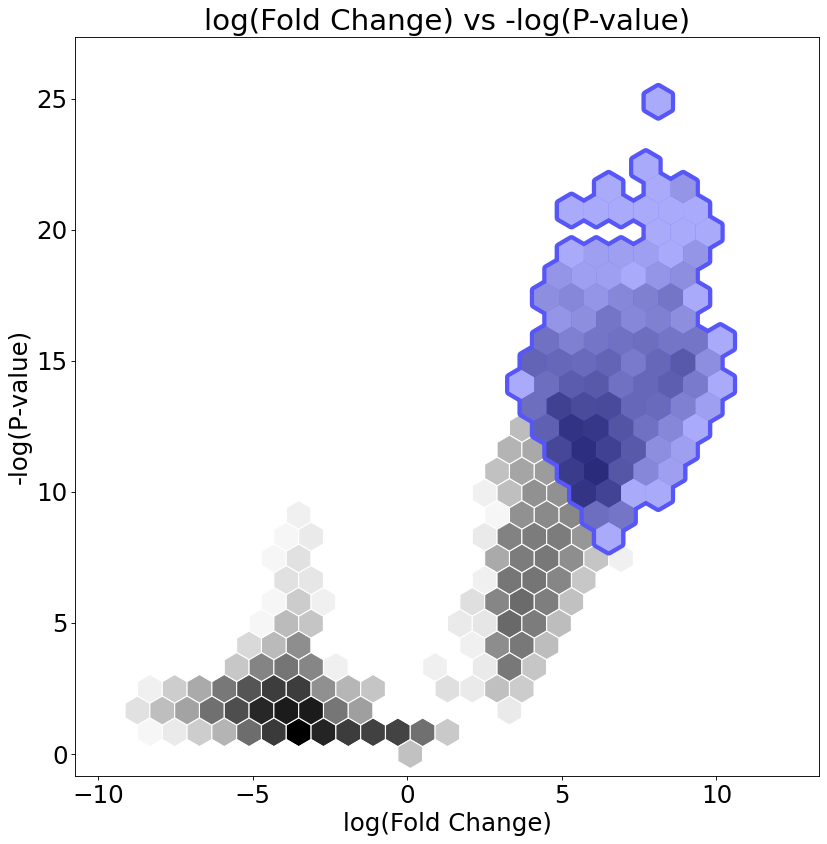

(-10.735610373902963, 13.334223068602926, -0.8329379238887278, 27.369964117469774)


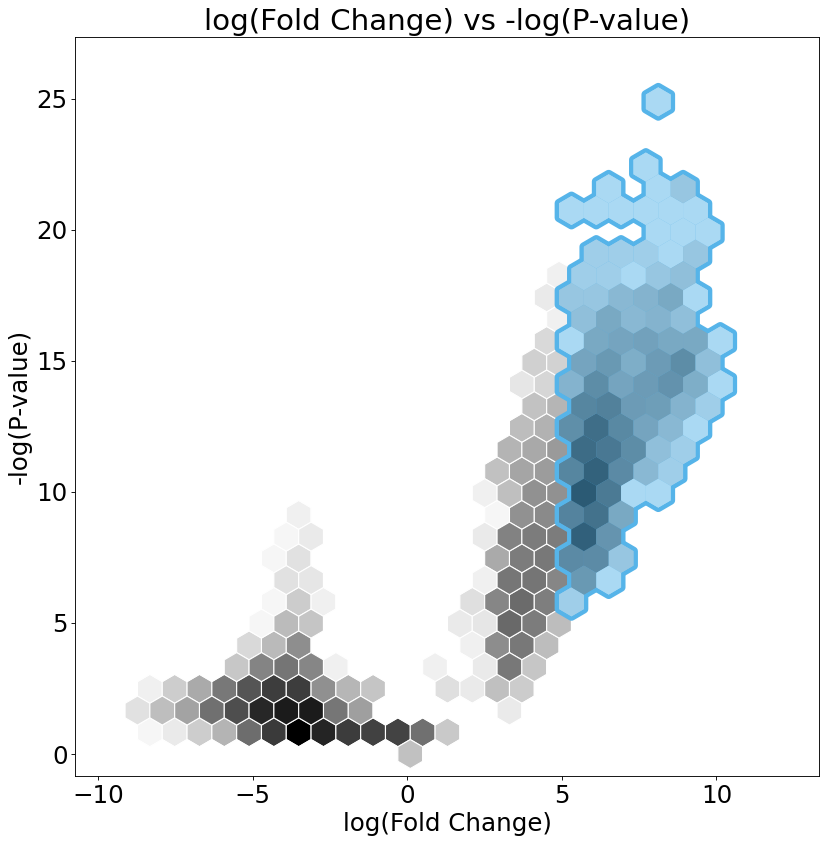

(-18.34857663886301, 12.263528443333284, -10.735610373902963, 13.334223068602926)


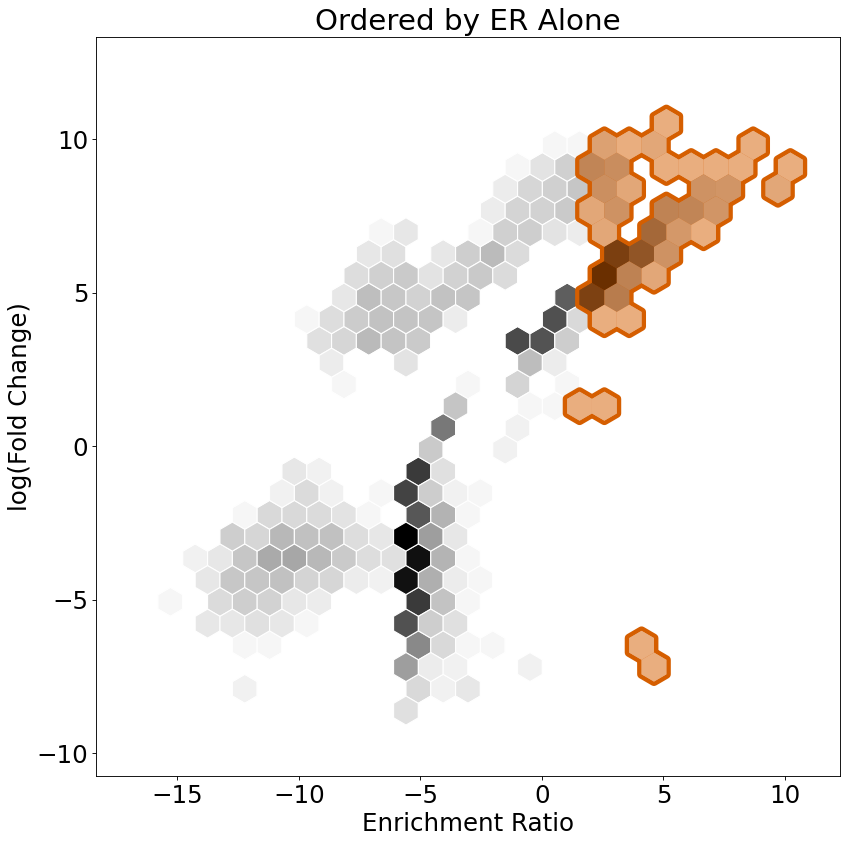

(-18.34857663886301, 12.263528443333284, -10.735610373902963, 13.334223068602926)


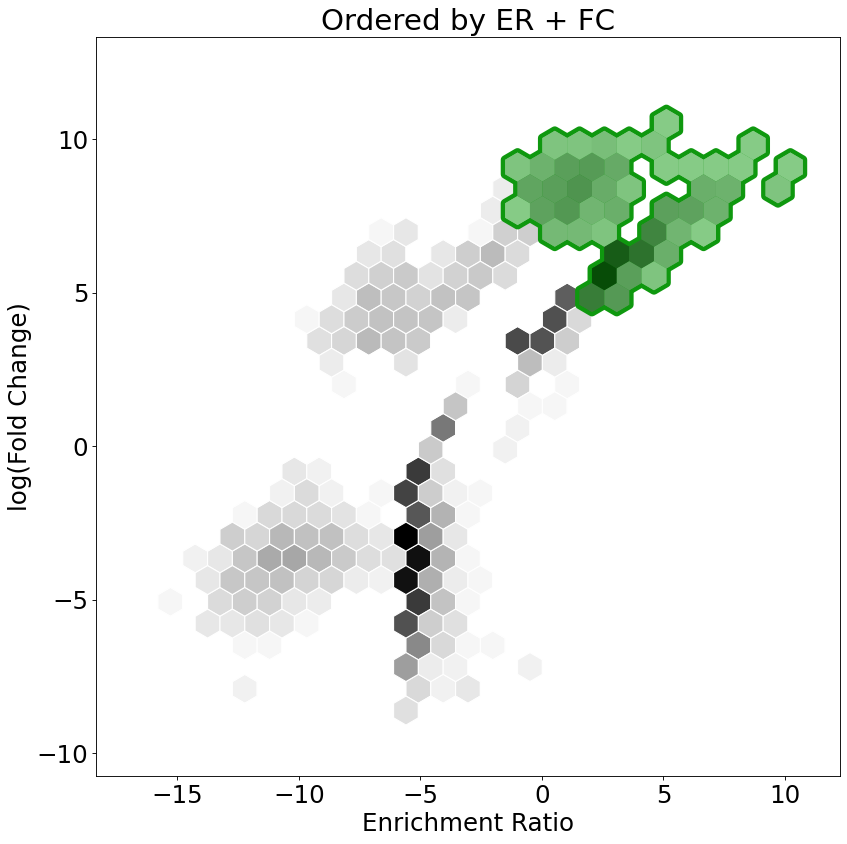

In [12]:
volcano_ordering = (
    np.array([(val[0] + 6) * val[1] if val[1] > 0 else 0 for val in y_raw])
    if protein_of_interest == "MDM2"
    else np.array([val[0] * val[1] for val in y_raw])
)
plot_fancy_hexbin_relations(
    1,
    0,
    datapoints=y_raw,
    ordering=volcano_ordering,
    all_positives=None,
    line_color='#5757F9',
    top_k=top_k_size,
)

fc_alone_mdm2_ordering = [y[1] for y in y_raw]
plot_fancy_hexbin_relations(
    1,
    0,
    datapoints=y_raw,
    ordering=fc_alone_mdm2_ordering,
    all_positives=None,
    line_color='#56B4E9',
    top_k=top_k_size,
)

er_mdm2_ordering = [y[2] for y in y_raw]

plot_fancy_hexbin_relations(
    2,
    1,
    datapoints=y_raw,
    ordering=er_mdm2_ordering,
    all_positives=None,
    line_color='#D55E00',
    title='Ordered by ER Alone',
    top_k=top_k_size,
)

er_fc_joint_mdm2_ordering = [y[2] + y[1] for y in y_raw]
plot_fancy_hexbin_relations(
    2,
    1,
    datapoints=y_raw,
    ordering=er_fc_joint_mdm2_ordering,
    all_positives=None,
    line_color='#0F980F',
    title='Ordered by ER + FC',
    top_k=top_k_size,
)

drop C
max is  122.0


/home/yitongt/ml_phage/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV'))
/home/yitongt/ml_phage/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV'))


drop C
max is  115.0
drop C
max is  69.0


/home/yitongt/ml_phage/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV'))
/home/yitongt/ml_phage/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV'))


drop C
max is  81.0


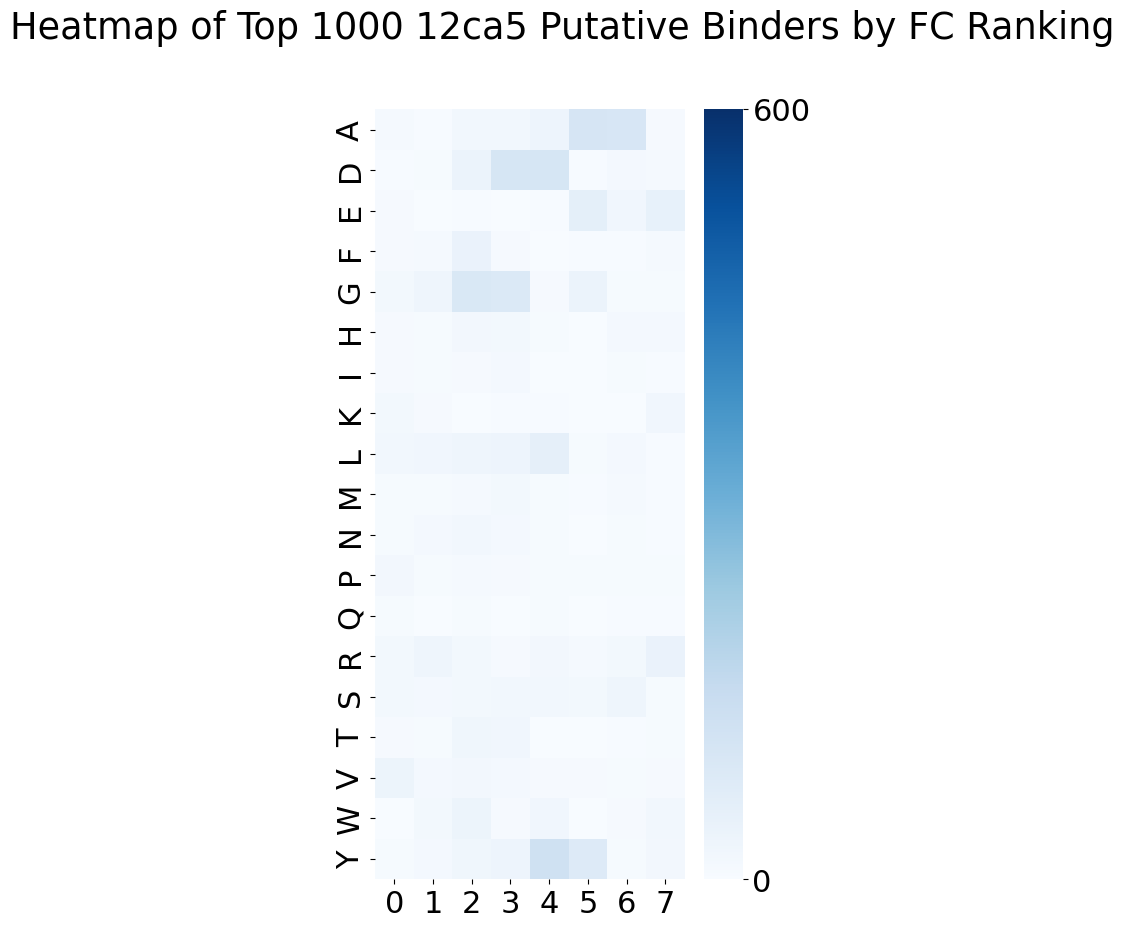

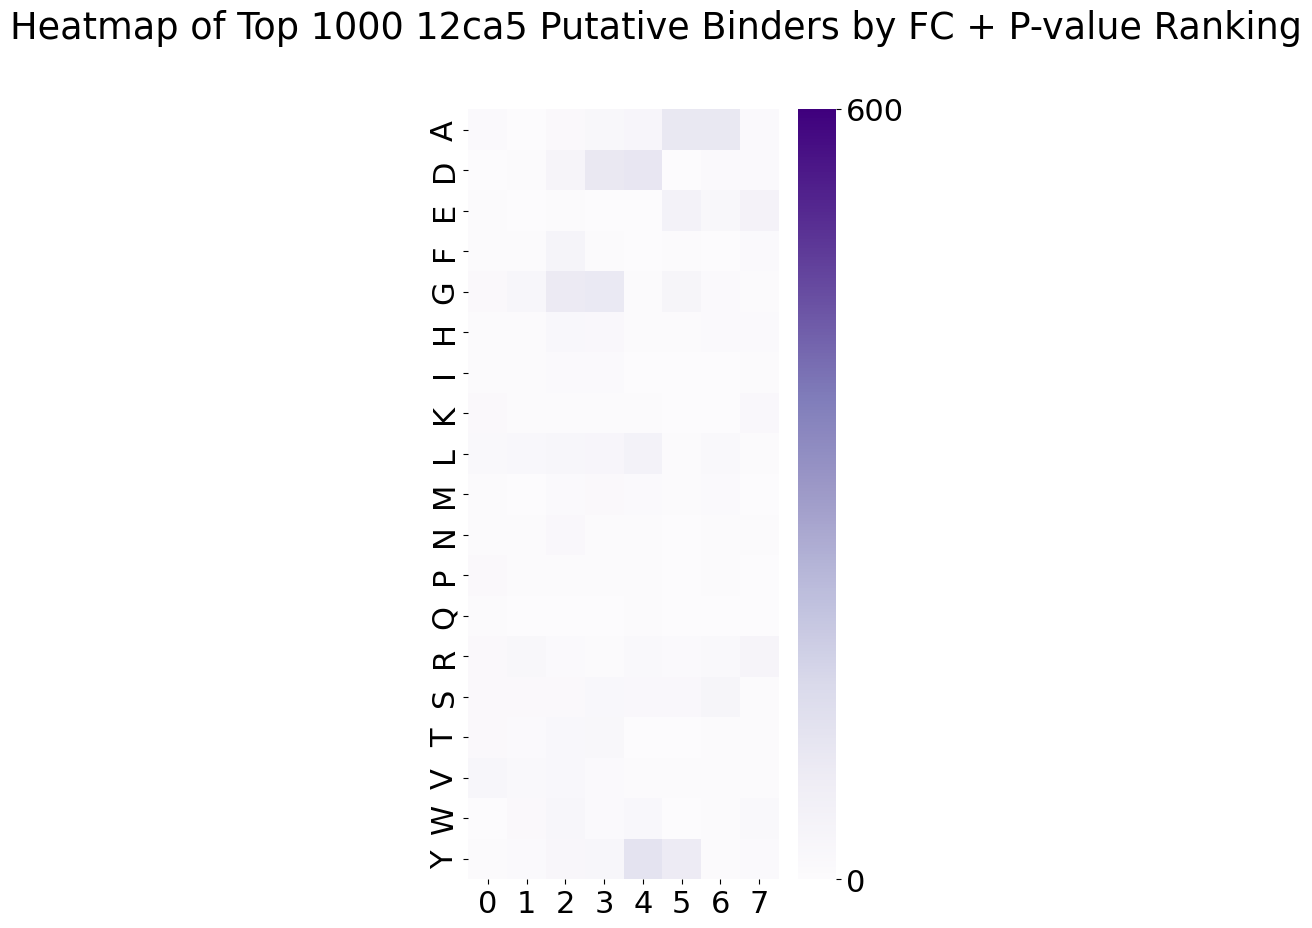

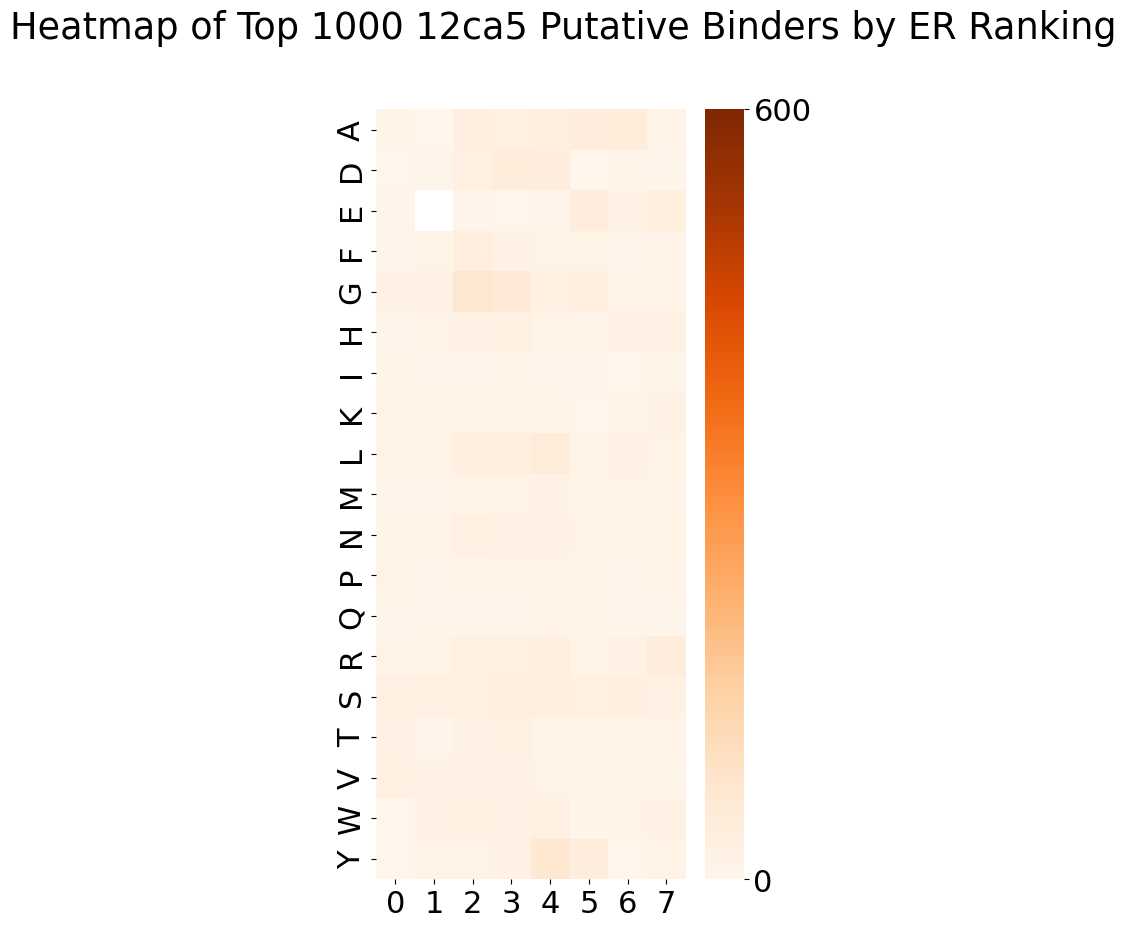

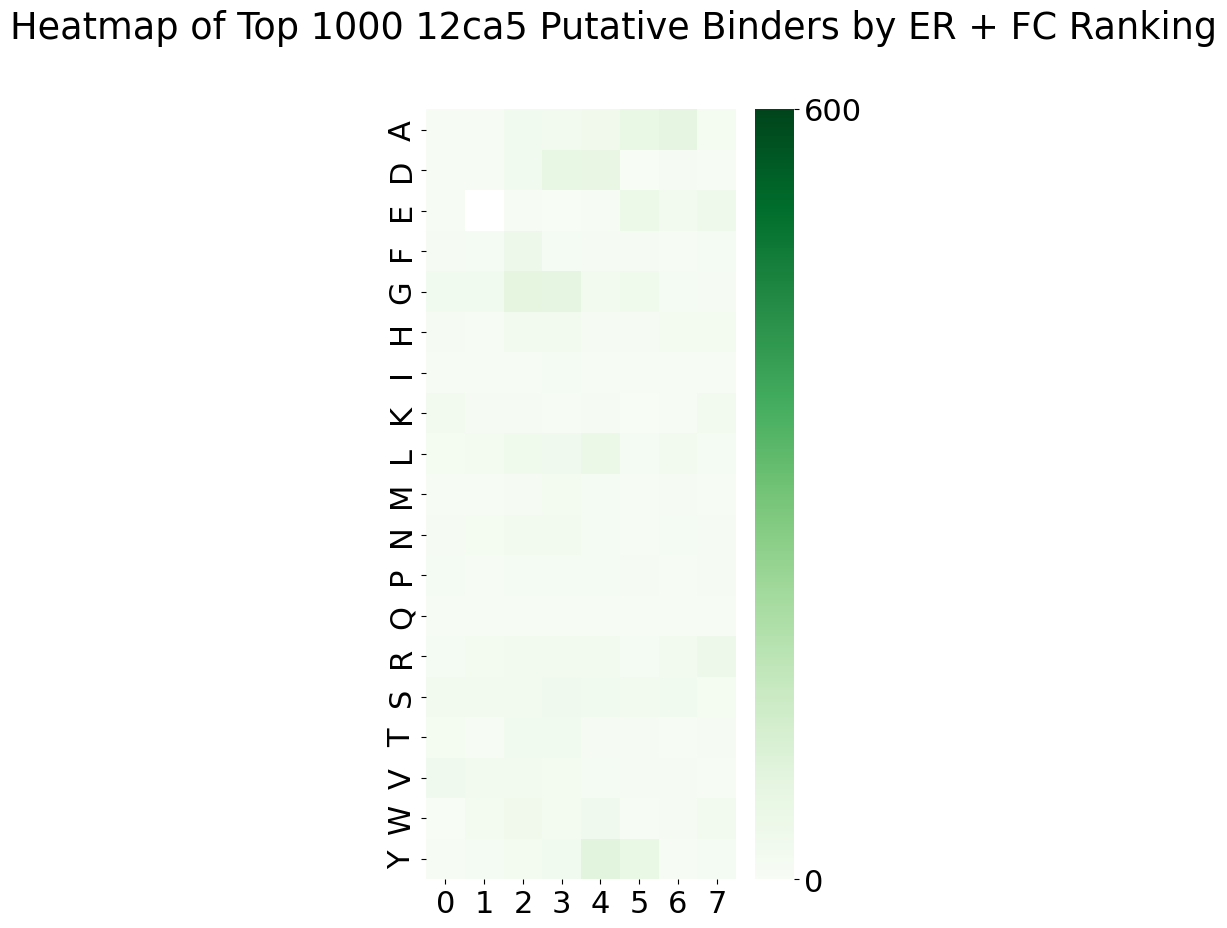

In [13]:
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by FC Ranking", fc_alone_mdm2_ordering, 'Blues')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by FC + P-value Ranking", volcano_ordering, 'Purples')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by ER Ranking", er_mdm2_ordering, 'Oranges')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by ER + FC Ranking", er_fc_joint_mdm2_ordering, 'Greens')

In [14]:
cross_validation_results = experiment.Experiment().run_cross_validation_experiment(
    X=X,
    y=y_raw,
    model_architecture=partial(
        rnn.ThreeChannelRegressionRNN_gelu, loss=multi_channel_mse, width=64
    ),
    optimizer=partial(
        keras.optimizers.Adam, learning_rate=0.0005, weight_decay=0.5
    ),
    n_splits=10,
    load_trained_model=True,
    model_save_name=model_save_name,
    normalize=True,
    batch_size=128,
    num_epochs=5,
)


(-4.212047333033321, 8.26147482014639, 0.5275389556616962, 11.377106734663345)


/home/yitongt/ml_phage/src/analysis/hit_rate_analysis.py:179: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_pred = np.vstack(result.y_pred_rescaled for result in cross_validation_results)
/home/yitongt/ml_phage/src/analysis/hit_rate_analysis.py:180: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(result.y_test for result in cross_validation_results)


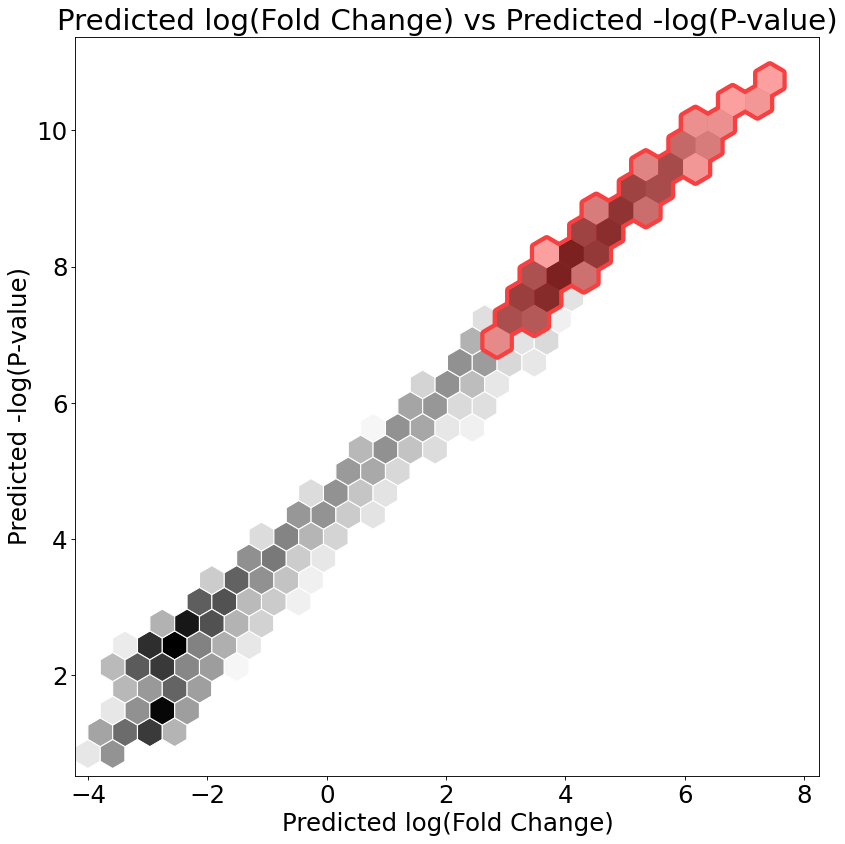

(-4.212047333033321, 8.26147482014639, 0.5275389556616962, 11.377106734663345)


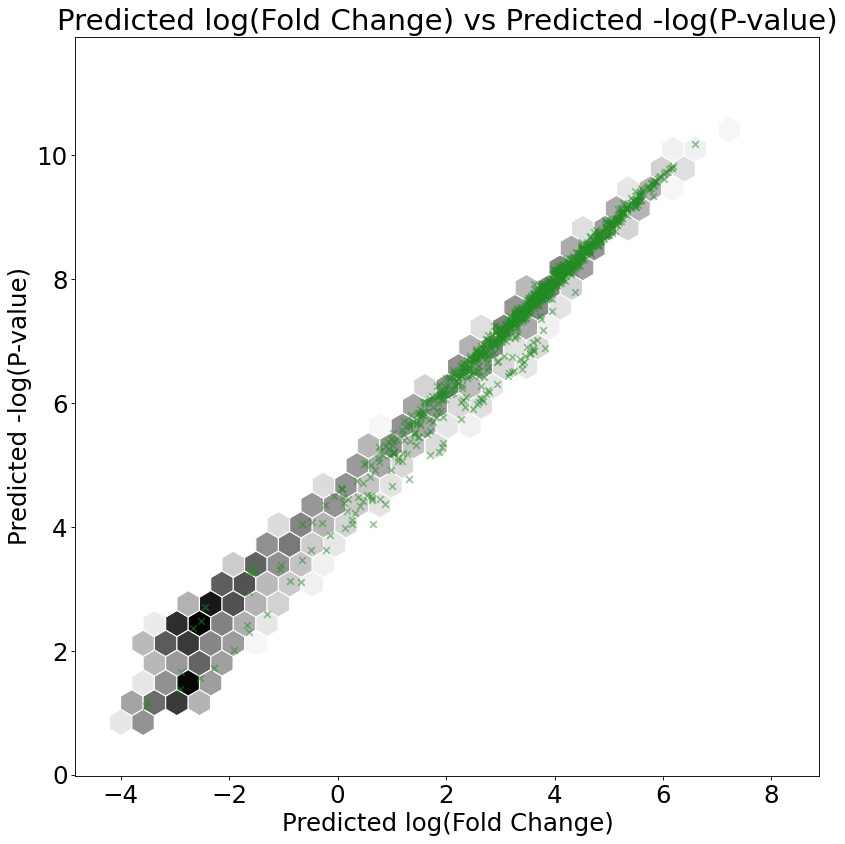

In [15]:
bilstm_ordering, y_pred = benchmark_cross_validated_hit_rate(
    cross_validation_results=cross_validation_results,
    y_raw=y_raw,
    peptides=peptides,
    proxy_ranking_lambda=proxy_ranking_lambda,
    top_k_size=top_k_size,
    motif_dectection_func=motif_dectection_func,
)

drop C
max is  143.0


/home/yitongt/ml_phage/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV'))


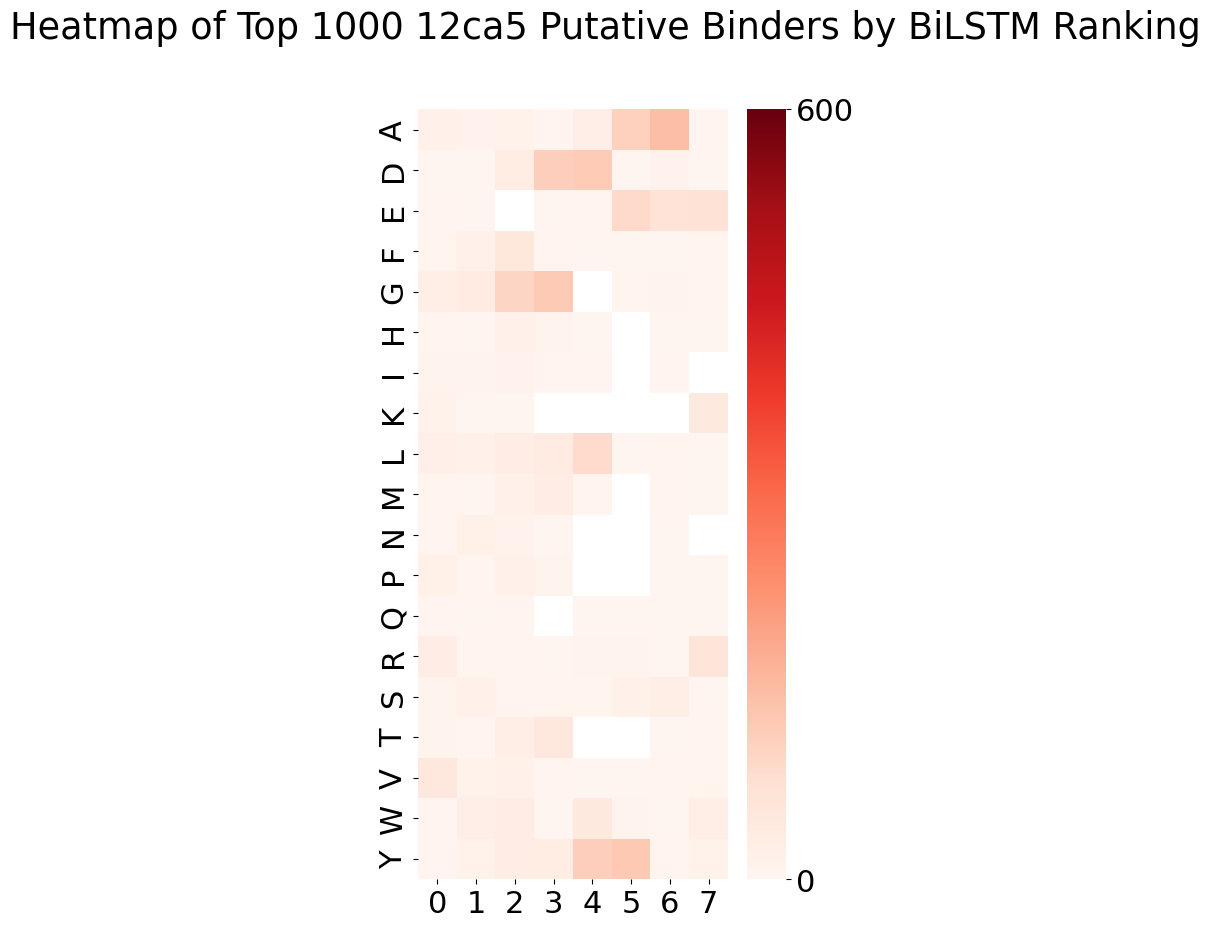

In [16]:
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by BiLSTM Ranking", bilstm_ordering, 'Reds')

In [17]:
rankings=[
(
    bilstm_ordering, 'BiLSTM Model Ranking', '#F94040'
),
(
    er_mdm2_ordering, 'ER Ranking', '#D55E00'
),
(
    er_fc_joint_mdm2_ordering, 'Joint ER/FC Ranking', '#0F980F'
),
(
    volcano_ordering, 'Joint FC/Pval Ranking', '#5757F9'
),
(
    fc_alone_mdm2_ordering, 'FC Ranking', '#56B4E9'
),
]

In [18]:
from matplotlib.pyplot import figure

figure(figsize=(12, 12), dpi=80)

<Figure size 960x960 with 0 Axes>

<Figure size 960x960 with 0 Axes>

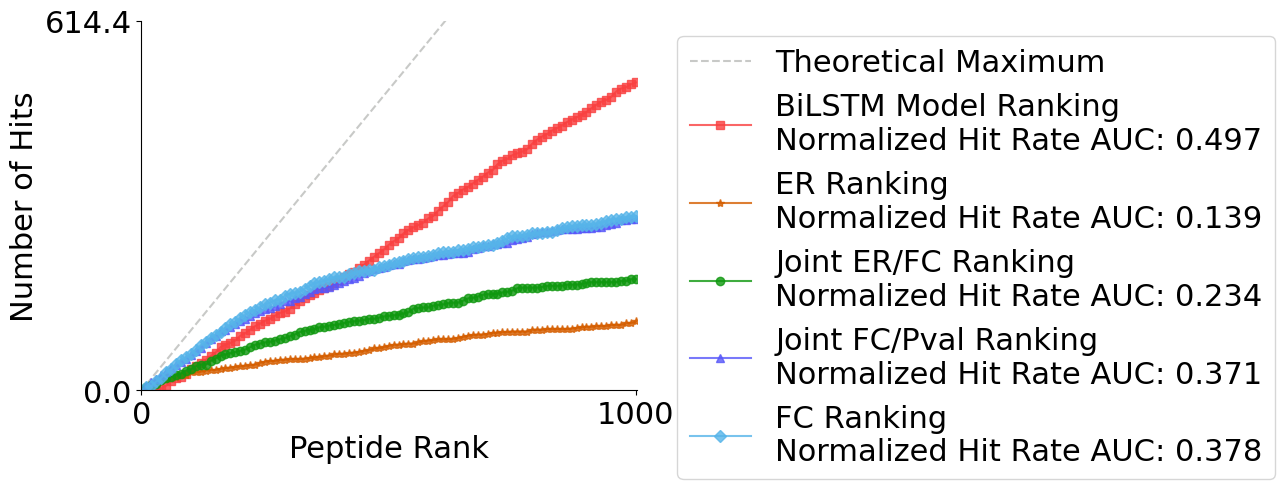

0.49665346534653465

In [19]:
plot_ratio_by_ranking(
    peptides=peptides,
    y_rankings=rankings,
    title="",
    peptide_dataset_size=top_k_size,
    hit_rate_func=seq_contains_mdm2_motif if protein_of_interest =="MDM2" else seq_contains_12ca5_motif,
    save_file='mdm2_hit_rankings.csv' if protein_of_interest =='MDM2' else '12ca5_hit_rankings.csv',
)